### SVR regression, housing data test with the TransformedTargetRegressor

In [1]:
# usual imports in a classic ML pipeline for Regression
# pip install numpy
# pip install pandas
# pip install seaborn
# pip install scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import pipelines, SVM etc.
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# this helps us with all the scaling, both X and y are scaled
# automatically!
from sklearn.compose import TransformedTargetRegressor

In [2]:
# load the data
df = pd.read_csv("Housing.csv")

# let's quickly see the first 5 rows of data
df.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished


### STEP 2: Handle missing/duplicate values and HANDLE ALL CATEGORICAL VARIABLES CORRECTLY

**Case 1: Binary variables (only two options)**

If your dataset does not have any binary variables => remove/disable the code cell below.

In [3]:
# this just converts the value of column to 0 or 1
# factorize in pandas works too, but only one column at a time
from sklearn.preprocessing import LabelEncoder
variables = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

In [4]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


**Case 2: Ordinal variables (categories that have an order/rank -> can be compared)**

In [5]:
# we don't have ordinal categories here, so we'll skip these, check the diamonds example later for this

**Case 3: Nominal categories (categories that can't be compared numerically)**

In [6]:
# this makes multiple columns with the variable (Separate for yes/no)
from sklearn.preprocessing import OneHotEncoder
variables = ['furnishingstatus']

# use encoder
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [7]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0,0


In [8]:
# see the materials (Rovaniemi/Oulu/Helsinki), we can make a small optimization
# => remove the last new boolean variable, since it's going to be represented
# by a straight line of zeroes
df = df.drop("furnishingstatus_unfurnished", axis=1)

In [9]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0


### STEP 3: Data is good to go (all numbers) => train model etc.

In [10]:
# first step, we split our data into SUPPORT variables and the TARGET variable
# X => support variables, y => target variable

# X => list of support variables the model uses 
# while predicting the target variable with the model
X = df.drop("price", axis=1)

# our target variable is y
y = df['price']

In [11]:
# secondly, train/test -split with scikit-learn's helper function
# 0.3 for testing => 30% of data is reserved for testing purposes
# and based on that => it's deduced that 70% will be in the training data

# you can also define the random state, which is sometimes useful
# if you want to "lock down" all the randomness in order to get same results every time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

**We'll use Pipeline + TransformedTargetRegressor in order to scale both X and y -automatically**

In [12]:
# create the model and train it with the data
# use pipeline to scale the X-values automatically with StandardScaler
pipeline = make_pipeline(StandardScaler(), svm.SVR())

# use TransformedTargetRegressor to automatically scale y
# and pipelines above to automatically scale X
model = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=MinMaxScaler()
)

# train the model
model.fit(X_train, y_train)

,"regressor regressor: object, default=NoneRegressor object such as derived from:class:`~sklearn.base.RegressorMixin`. This regressor willautomatically be cloned each time prior to fitting. If `regressor isNone`, :class:`~sklearn.linear_model.LinearRegression` is created and used.","Pipeline(step...svr', SVR())])"
,"transformer transformer: object, default=NoneEstimator object such as derived from:class:`~sklearn.base.TransformerMixin`. Cannot be set at the same timeas `func` and `inverse_func`. If `transformer is None` as well as`func` and `inverse_func`, the transformer will be an identitytransformer. Note that the transformer will be cloned during fitting.Also, the transformer is restricting `y` to be a numpy array.",MinMaxScaler()
,"func func: function, default=NoneFunction to apply to `y` before passing to :meth:`fit`. Cannot be setat the same time as `transformer`. If `func is None`, the function used will bethe identity function. If `func` is set, `inverse_func` also needs to beprovided. The function needs to return a 2-dimensional array.",None
,"inverse_func inverse_func: function, default=NoneFunction to apply to the prediction of the regressor. Cannot be set atthe same time as `transformer`. The inverse function is used to returnpredictions to the same space of the original training labels. If`inverse_func` is set, `func` also needs to be provided. The inversefunction needs to return a 2-dimensional array.",None
,"check_inverse check_inverse: bool, default=TrueWhether to check that `transform` followed by `inverse_transform`or `func` followed by `inverse_func` leads to the original targets.",True
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm.If none is given, 'rbf' will be used. If a callable is given it isused to precompute the kernel matrix.For an intuitive visualization of different kernel typessee :ref:`sphx_glr_auto_examples_svm_plot_svm_regression.py`",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'


In [13]:
# we need to create test predictions based on our earlier reserved test dataset
# this data has never been seen by the model by now
predictions = model.predict(X_test)

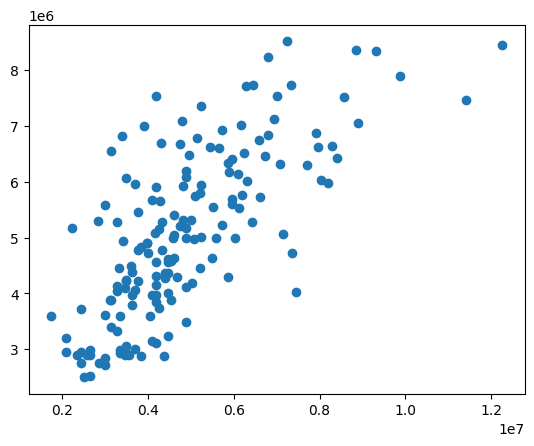

In [14]:
# let's plot how far the predictions are from the real target values (y)
# in the test dataset

# if the values follow a diagonal line (from bottom left to top right)
# => we have good predictions with the model
# we basically compare the predicted values to the actual true values 
# and compare the differences
plt.scatter(y_test, predictions)
plt.show()

In [15]:
# MAE = Mean average error
mae = metrics.mean_absolute_error(y_test, predictions)
print("MAE:")
print(f"{round(mae, 2)} $")

# MSE = Mean squared error
mse = metrics.mean_squared_error(y_test, predictions)
print("\nMSE:")
print(f"{round(mse, 2)} $^2")

# RMSE = Root Mean Squared Error
rmse = np.sqrt(mse)
print("\nRMSE:")
print(f"{round(rmse, 2)} $")

# R-square (or R2) - how well the model describes the original dataset
# 1 => model describes the data perfectly
# 0 => model doesn't describe the data at all
r2 = metrics.r2_score(y_test, predictions)
print("\nR-squared:")
print(f"{round(r2, 2)}")

# SCALED VERSIONS OF THE METRICS, only use MAE and RMSE
y_test_scaled = model.transformer_.transform(y_test.values.reshape(-1, 1)).ravel()
predictions_scaled = model.transformer_.transform(predictions.reshape(-1, 1)).ravel()

# calculate the scaled MAE and RMSE
mae_scaled = metrics.mean_absolute_error(y_test_scaled, predictions_scaled)
rmse_scaled = np.sqrt(metrics.mean_squared_error(y_test_scaled, predictions_scaled))

print(f"\nMAE scaled: {round(mae_scaled, 2)}")
print(f"\nRMSE scaled: {round(rmse_scaled, 2)}")


MAE:
956053.37 $

MSE:
1618973809706.21 $^2

RMSE:
1272389.02 $

R-squared:
0.5

MAE scaled: 0.08

RMSE scaled: 0.11


C:\Users\tuomas.valtanen\AppData\Local\Temp\ipykernel_8744\2920752686.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - predictions))


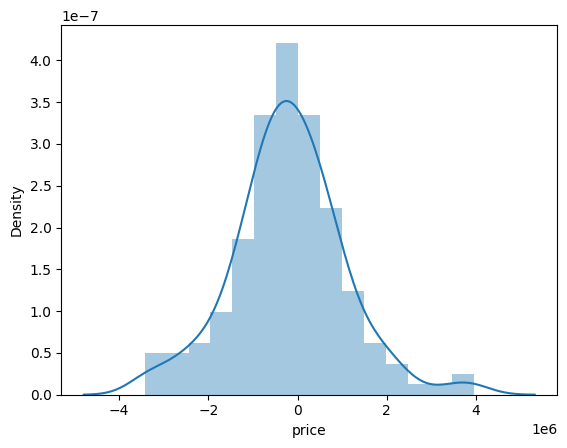

In [16]:
# if the prediction distribution is far from standard normal distritbuion
# then the model is not probably good enough
# distplot is deprecated and will be removed in future seaborn versions
# but not direct replacement has been created so far
sns.distplot((y_test - predictions))
plt.show()
plt.close()

In [17]:
X.columns

Index(['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom',
       'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea',
       'furnishingstatus_furnished', 'furnishingstatus_semi-furnished'],
      dtype='object')

In [18]:
# usually in GUI application we save the model-object / variable into a file (by using joblib-module)
# and in the GUI application => we load the saved model from the file
# and use the model just like here below

# map all the variables from the user
# into a Python dictionary
# the variable names have to match with the original dataset
tester_row = {
    'area': 3500, 
    'bedrooms': 3, 
    'bathrooms': 1, 
    'stories': 1, 
    'mainroad': 0, 
    'guestroom': 1,
    'basement': 1, 
    'hotwaterheating': 1, 
    'airconditioning': 1, 
    'parking': 5, 
    'prefarea': 0,
    'furnishingstatus_furnished': 0, 
    'furnishingstatus_semi-furnished': 0
}

# convert to pandas format
tester_row = pd.DataFrame([tester_row])

**No need to invert scaling here, Pipeline + TransformedTargetRegressor scale X/y -automatically!**

In [19]:
# get the output/result from the model
# based on the user's given new data (above code cell)
result = model.predict(tester_row)[0]

print()
print(f"Predicted price for this house:")
print(f"$ {round(float(result), 2)}")
print("----------------------------")


Predicted price for this house:
$ 6364329.9
----------------------------
